# The Habitual DDPG Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that minimise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting


Okay so new idea! DDPG seems pretty good so far. How about we have the Q function take latent states as input and use the VAEs good latent features as input. Then we'll have
- Q(o, a)
- p(s|o) and p(o|s)
- p(s'|s, a)
- V(o) or U(o)



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

from ddpg import *

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make('MountainCarContinuous-v0')

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [4]:
# class Buffer:
#     def __init__(self,
#                  buffer_capacity=100000,
#                  batch_size=64,
#                  gamma=0.99,
#                  observation_dim=2,
#                  action_dim=1,
#                  critic_optimizer="adam",
#                  actor_optimizer="adam"):
#
#         # Number of "experiences" to store at max
#         self.buffer_capacity = buffer_capacity
#         # Num of tuples to train on.
#         self.batch_size = batch_size
#
#         # Its tells us num of times record() was called.
#         self.buffer_counter = 0
#
#         # Instead of list of tuples as the exp.replay concept go
#         # We use different np.arrays for each tuple element
#         self.state_buffer = np.zeros((self.buffer_capacity, observation_dim))
#         self.action_buffer = np.zeros((self.buffer_capacity, action_dim))
#         self.reward_buffer = np.zeros((self.buffer_capacity, 1))
#         self.next_state_buffer = np.zeros((self.buffer_capacity, observation_dim))
#
#         self.gamma = gamma
#
#         self.critic_optimizer = critic_optimizer
#         self.actor_optimizer = actor_optimizer
#
#     # Takes (s,a,r,s') obervation tuple as input
#     def record(self, obs_tuple):
#         # Set index to zero if buffer_capacity is exceeded,
#         # replacing old records
#         index = self.buffer_counter % self.buffer_capacity
#
#         self.state_buffer[index] = obs_tuple[0]
#         self.action_buffer[index] = obs_tuple[1]
#         self.reward_buffer[index] = obs_tuple[2]
#         self.next_state_buffer[index] = obs_tuple[3]
#
#         self.buffer_counter += 1
#
#     # clears the buffer
#     def clear(self):
#         self.state_buffer= []
#         self.action_buffer = []
#         self.reward_buffer = []
#         self.next_state_buffer = []
#
#     # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
#     # TensorFlow to build a static graph out of the logic and computations in our function.
#     # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
#     @tf.function
#     def update(
#             self, state_batch, action_batch, reward_batch, next_state_batch,
#     ):
#         # Training and updating Actor & Critic networks.
#         # See Pseudo Code.
#         with tf.GradientTape() as tape:
#             target_actions = target_actor(next_state_batch, training=True)
#             y = reward_batch + self.gamma * target_critic(
#                 [next_state_batch, target_actions], training=True
#             )
#             critic_value = critic_model([state_batch, action_batch], training=True)
#             critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
#
#         critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
#         self.critic_optimizer.apply_gradients(
#             zip(critic_grad, critic_model.trainable_variables)
#         )
#
#         with tf.GradientTape() as tape:
#             actions = actor_model(state_batch, training=True)
#             critic_value = critic_model([state_batch, actions], training=True)
#             # Used `-value` as we want to maximize the value given
#             # by the critic for our actions
#             actor_loss = -tf.math.reduce_mean(critic_value)
#
#         actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
#         self.actor_optimizer.apply_gradients(
#             zip(actor_grad, actor_model.trainable_variables)
#         )
#
#     # We compute the loss and update parameters
#     def learn(self):
#         # Get sampling range
#         record_range = min(self.buffer_counter, self.buffer_capacity)
#         # Randomly sample indices
#         batch_indices = np.random.choice(record_range, self.batch_size)
#
#         # Convert to tensors
#         state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
#         action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
#         reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
#         reward_batch = tf.cast(reward_batch, dtype=tf.float32)
#         next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
#
#         self.update(state_batch, action_batch, reward_batch, next_state_batch)


In [5]:
# def get_actor(observation_dim, action_max):
#     # Initialize weights between -3e-3 and 3-e3
#     last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
#
#     inputs = layers.Input(shape=(observation_dim,))
#     out = layers.Dense(16, activation="relu")(inputs)
#     out = layers.Dense(32, activation="relu")(out)
#     out = layers.Dense(16, activation="relu")(out)
#     outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
#
#     # Our upper bound is 2.0 for Pendulum.
#     outputs = outputs * action_max
#     model = tf.keras.Model(inputs, outputs)
#     return model
#
#
# def get_critic(observation_dim, action_dim):
#     # State as input
#     state_input = layers.Input(shape=(observation_dim, ))
#     state_out = layers.Dense(16, activation="relu")(state_input)
#     state_out = layers.Dense(32, activation="relu")(state_out)
#
#     # Action as input
#     action_input = layers.Input(shape=action_dim)
#     action_out = layers.Dense(32, activation="relu")(action_input)
#
#     # Both are passed through seperate layer before concatenating
#     concat = layers.Concatenate()([state_out, action_out])
#
#     # was 256
#     out = layers.Dense(128, activation="relu")(concat)
#     out = layers.Dense(128, activation="relu")(out)
#     outputs = layers.Dense(1)(out)
#
#     # Outputs single value for give state-action
#     model = tf.keras.Model([state_input, action_input], outputs)
#
#     return model

In [6]:
# class BasicDDPG:
#
#     def __init__(self, actor, critic, target_actor, target_critic, tau,
#                  buffer_capacity=100000,
#                  batch_size=64,
#                  gamma=0.99,
#                  observation_dim=2,
#                  action_dim=1,
#                  critic_optimizer="adam",
#                  actor_optimizer="adam"):
#
#         self.actor_model = actor
#         self.critic_model = critic
#
#         self.target_actor = target_actor
#         self.target_critic = target_critic
#
#         # self.buffer = buffer
#         self.tau = tau
#
#         # BUFFER
#
#         # Number of "experiences" to store at max
#         self.buffer_capacity = buffer_capacity
#         # Num of tuples to train on.
#         self.batch_size = batch_size
#
#         # Its tells us num of times record() was called.
#         self.buffer_counter = 0
#
#         # Instead of list of tuples as the exp.replay concept go
#         # We use different np.arrays for each tuple element
#         self.state_buffer = np.zeros((self.buffer_capacity, observation_dim))
#         self.action_buffer = np.zeros((self.buffer_capacity, action_dim))
#         self.reward_buffer = np.zeros((self.buffer_capacity, 1))
#         self.next_state_buffer = np.zeros((self.buffer_capacity, observation_dim))
#
#         self.gamma = gamma
#
#         self.critic_optimizer = critic_optimizer
#         self.actor_optimizer = actor_optimizer
#
#     def update_actor_target(self):
#         update_target(self.target_actor.variables, self.actor_model.variables, self.tau)
#
#     def update_critic_target(self):
#         update_target(self.target_critic.variables, self.critic_model.variables, self.tau)
#
#     # Takes (s,a,r,s') obervation tuple as input
#     def record(self, obs_tuple):
#         # Set index to zero if buffer_capacity is exceeded,
#         # replacing old records
#         index = self.buffer_counter % self.buffer_capacity
#
#         self.state_buffer[index] = obs_tuple[0]
#         self.action_buffer[index] = obs_tuple[1]
#         self.reward_buffer[index] = obs_tuple[2]
#         self.next_state_buffer[index] = obs_tuple[3]
#
#         self.buffer_counter += 1
#
#     # clears the buffer
#     def clear(self):
#         self.state_buffer= []
#         self.action_buffer = []
#         self.reward_buffer = []
#         self.next_state_buffer = []
#
#     # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
#     # TensorFlow to build a static graph out of the logic and computations in our function.
#     # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
#     @tf.function
#     def update(
#             self, state_batch, action_batch, reward_batch, next_state_batch,
#     ):
#         # Training and updating Actor & Critic networks.
#         # See Pseudo Code.
#         with tf.GradientTape() as tape:
#             target_actions = self.target_actor(next_state_batch, training=True)
#             y = reward_batch + self.gamma * self.target_critic(
#                 [next_state_batch, target_actions], training=True
#             )
#             critic_value = self.critic_model([state_batch, action_batch], training=True)
#             critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
#
#         critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
#         self.critic_optimizer.apply_gradients(
#             zip(critic_grad, self.critic_model.trainable_variables)
#         )
#
#         with tf.GradientTape() as tape:
#             actions = self.actor_model(state_batch, training=True)
#             critic_value = self.critic_model([state_batch, actions], training=True)
#             # Used `-value` as we want to maximize the value given
#             # by the critic for our actions
#             actor_loss = -tf.math.reduce_mean(critic_value)
#
#         actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
#         self.actor_optimizer.apply_gradients(
#             zip(actor_grad, self.actor_model.trainable_variables)
#         )
#
#     # We compute the loss and update parameters
#     def learn(self):
#         # Get sampling range
#         record_range = min(self.buffer_counter, self.buffer_capacity)
#         # Randomly sample indices
#         batch_indices = np.random.choice(record_range, self.batch_size)
#
#         # Convert to tensors
#         state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
#         action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
#         reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
#         reward_batch = tf.cast(reward_batch, dtype=tf.float32)
#         next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
#
#         self.update(state_batch, action_batch, reward_batch, next_state_batch)
#
#     def train(self):
#         self.learn()
#         self.update_actor_target()
#         self.update_critic_target()
#
#
# # This update target parameters slowly
# # Based on rate `tau`, which is much less than one.
# @tf.function
# def update_target(target_weights, weights, tau):
#     for (a, b) in zip(target_weights, weights):
#         a.assign(b * tau + a * (1 - tau))

In [7]:
actor_model = get_actor(2, 1)
critic_model = get_critic(2, 1)

target_actor = get_actor(2, 1)
target_critic = get_critic(2, 1)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

# buffer = Buffer(50000, 64, 0.99, 2, 1, critic_optimizer, actor_optimizer)

ddpg = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [8]:
t_max = 1000
num_episodes = 50

min_reward_cutoff = -1000
min_reward_set = -0.5

reward_increase = 0

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    total_reward = 0

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.2)
    o = transform_observations(o, observation_max, observation_min, [0, 0])


    for i in range(len(a)):

        prev_state = o[i]
        state = o[i+1]
        action = a[i]
        reward = r[i] + reward_increase

        # if reward < 0:
        #     print("yes")

        total_reward += reward

        # ddpg.buffer.record((prev_state, action, reward, state))
        # # episodic_reward += reward
        #
        # ddpg.buffer.learn()

        ddpg.record((prev_state, action, reward, state))
        # episodic_reward += reward

        ddpg.train()

        # ddpg.learn()
        #
        # ddpg.update_actor_target()
        # ddpg.update_critic_target()

        # buffer.record((prev_state, action, reward, state))
        # # episodic_reward += reward
        # #
        # buffer.learn()
        # update_target(target_actor.variables, actor_model.variables, tau)
        # update_target(target_critic.variables, critic_model.variables, tau)

    print(total_reward)

    acts = ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))
    print(np.max(acts), np.min(acts))


2022-09-06 21:52:17.536133: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


-33.424322627462075
0.06587567 0.014397912
-35.35045031681202
0.051338397 0.022356827
72.27156689120763
0.07101009 0.017263131
-32.70369907036973
0.6897657 -0.024086904
90.77576154085813
0.2173323 -0.031274978
85.04573819991703
0.963663 -0.0074115032
74.0665016351666
0.9999845 -0.085101694
-32.47587974133253
0.9999813 -0.14758924
-28.873203949061825
0.99999917 -0.15841354
88.82792863606231
1.0 -0.13598327
-30.032951099197184
0.99999976 -0.17659165
87.90769479308469
0.9999994 -0.2000603
-32.16579916405158
1.0 -0.35338718
-35.31154210149196
0.99999976 -0.35647464
-31.158652382460517
1.0 0.99999976
77.2398679400852
1.0 -0.3716555
80.49772082162337
1.0 -0.38257816
-33.38279204495365
1.0 -0.41619313
86.00887659693429
1.0 -0.4270042
81.26184905768638
1.0 -0.4468089
78.30079055965817
1.0 -0.41408217
78.45110869198396
1.0 -0.3927032
84.58975929648372
0.99999976 -0.420844
75.01979424038088
1.0 -0.38102672
89.728579082291
0.99999976 -0.28652906
-32.68142277430651
1.0 -0.43215403
81.5858470321359

In [9]:
ddpg.critic_model([(np.random.random(size=(10, 2))*2 - 1), (np.random.random(size=(10, 1))*2 - 1)])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[5626.16  ],
       [1278.3018],
       [2108.9463],
       [1838.2856],
       [1254.0297],
       [1424.8224],
       [1419.4712],
       [1090.5853],
       [4454.496 ],
       [8095.8843]], dtype=float32)>

In [10]:
ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.9993459 ],
       [-0.99995506],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [-0.9428255 ],
       [ 0.99999976],
       [ 1.        ],
       [-0.99981874]], dtype=float32)>

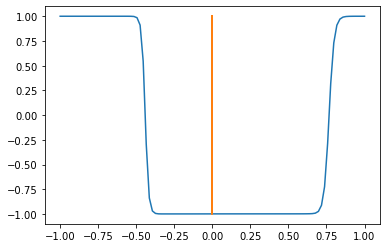

In [11]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = ddpg.actor_model(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.9999821 ]
 [-0.99998087]
 [-0.9999791 ]
 [-0.99997747]
 [-0.9999757 ]
 [-0.9999737 ]
 [-0.9999715 ]
 [-0.99996924]
 [-0.99996674]
 [-0.9999642 ]
 [-0.9999611 ]
 [-0.99995804]
 [-0.9999546 ]
 [-0.99995077]
 [-0.99994683]
 [-0.99994254]
 [-0.9999379 ]
 [-0.99993277]
 [-0.9999274 ]
 [-0.99992144]
 [-0.9999152 ]
 [-0.99990815]
 [-0.99990064]
 [-0.9998926 ]
 [-0.99988383]
 [-0.99987435]
 [-0.9998642 ]
 [-0.99985343]
 [-0.99984163]
 [-0.9998289 ]
 [-0.999815  ]
 [-0.9997995 ]
 [-0.99978274]
 [-0.99976444]
 [-0.9997448 ]
 [-0.999724  ]
 [-0.9997021 ]
 [-0.99967486]
 [-0.9996449 ]
 [-0.99961585]
 [-0.99958503]
 [-0.9995521 ]
 [-0.9995174 ]
 [-0.99947995]
 [-0.99944746]
 [-0.99941444]
 [-0.9993793 ]
 [-0.9993373 ]
 [-0.99929243]
 [-0.99924445]
 [-0.99919343]
 [-0.9991352 ]
 [-0.9990668 ]
 [-0.99896604]
 [-0.9988227 ]
 [-0.9986512 ]
 [-0.99841416]
 [-0.9979071 ]
 [-0.9787494 ]
 [-0.40187365]
 [ 0.88991016]
 [ 0.9971087 ]
 [ 0.9999282 ]
 [ 0.99999833]
 [ 0.99999976]
 [ 0.99999976]

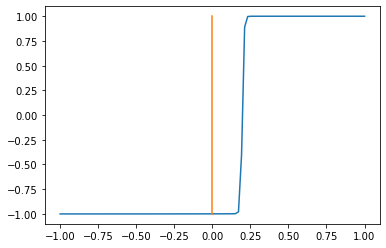

In [12]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = ddpg.actor_model(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [47]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = ddpg.actor_model(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

67
success
93.4595678463096
67
success
93.45142535320213
66
success
93.52785287271396
68
success
93.39642693701599
68
success
93.402857427759
66
success
93.5422590178614
67
success
93.44712708842327
67
success
93.45972519340326



KeyboardInterrupt



In [10]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

NameError: name 'act_net' is not defined

In [ ]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


In [ ]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X